In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt 
import pennylane as qml
import pennylane.numpy as np 
from main.operators import *
from main.VarQFT import *
from main.circuits import *

In this notebook we show how to employ our framework to obtain the ground state of a coupled system. We will consider two harmonic oscilator coupled by the Hooke's law. Let $X_j$ and $P_j$ the position and momentum operators of the $j$-th oscilator. The Hamiltonian is
$$ H =  P_1^2 + X_1^2 + P_2^2 + X_2^2 + ( X_1 - X_2)^2  . $$
We omit the factor $1/2$ for simplicity. To create the operator $X_1 - X_2$ we have to use the function ```distance```. We define a number of qubits for each system, and the total one will be the sum of them.

In [3]:
num_wires = 2
dev = qml.device( "default.qubit", 
                    wires=2*num_wires, shots=100)

In [4]:
X1, P1 = X_and_P_ops( range(num_wires), -5, 5 )    
X2, P2 = X_and_P_ops( range(num_wires,2*num_wires), -5, 5 )    

H12 = [ 
        X1.pow(2),
        X2.pow(2),
        P1.pow(2),
        P2.pow(2),
        distance( X1, X2 ).pow(2)
        ]
H12 

[<Hamiltonian: terms=1, wires=[0, 1]>,
 <Hamiltonian: terms=1, wires=[2, 3]>,
 <Hamiltonian: terms=1, wires=[0, 1]>,
 <Hamiltonian: terms=1, wires=[2, 3]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3]>]

Obtaining the groud state by ```numpy``` for comparisons.

In [5]:
H_matrix = ( np.kron( X1.pow(2).matrix()+P1.pow(2).matrix(), np.eye(2**num_wires) ) 
            + np.kron( np.eye(2**num_wires) , X2.pow(2).matrix()+P2.pow(2).matrix())
            + distance( X1, X2 ).pow(2).matrix()
            )
vals, vecs = np.linalg.eigh( H_matrix )
val = vals[0]
vec = vecs[:,0]

In [6]:
val

6.200897888990405

In [39]:
num_layers = 4
num_params = RY_ansatz( 2*num_wires, num_layers ).num_params
params     = 0.01 * np.random.randn(num_params)
var_state  = RY_ansatz( 2*num_wires, num_layers ).construct_circuit

In [40]:
varqft = VarFourier( H12, 
                    dev, 
                    var_state )

In [41]:
Params, Energies = varqft.run( params, max_iterations=100 )

Step:    100, Energy:     6.206365


In [43]:
dev = qml.device( "default.qubit", 
                    wires=2*num_wires )

ground_state = varqft.state( Params[-1], dev )

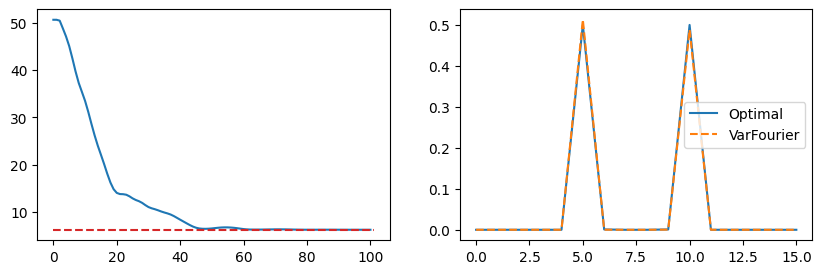

In [48]:
fig, ax = plt.subplots( 1, 2, figsize=(10,3) ) 

ax[0].plot( Energies )
ax[0].hlines( val, 0, len(Energies), colors='tab:red', linestyles='--' )
ax[1].plot( np.abs(vec)**2) 
ax[1].plot( np.abs(ground_state)**2, '--' ) 
ax[1].legend(['Optimal','VarFourier'], loc='best') 